In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
from matplotlib import pyplot as plt

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    


C:\Anaconda3\envs\py2_env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV
from time import time

In [3]:
# Converting the given pickled Enron data to a pandas dataframe
enron_df = pd.DataFrame.from_records(list(data_dict.values()))

# set the index of df to be the employees series:
employees = pd.Series(list(data_dict.keys()))
enron_df.set_index(employees, inplace=True)
enron_df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [4]:
print "Size of the enron dataframe : ",enron_df.shape

Size of the enron dataframe :  (146, 21)


In [5]:
print "Number of data points(people) in the dataset : ",len(enron_df)

Number of data points(people) in the dataset :  146


In [6]:
print "To find the number of Features in the Enron Dataset : ",len(enron_df.columns)

To find the number of Features in the Enron Dataset :  21


In [7]:
enron_df.groupby('poi').size()

poi
False    128
True      18
dtype: int64

So, in the given dataset there are 18 POI's and 128 non-POI's.  

Removing the column of __email_address__ from the enron_df as it is not of much used in this project.

In [8]:
enron_df.dtypes

bonus                        object
deferral_payments            object
deferred_income              object
director_fees                object
email_address                object
exercised_stock_options      object
expenses                     object
from_messages                object
from_poi_to_this_person      object
from_this_person_to_poi      object
loan_advances                object
long_term_incentive          object
other                        object
poi                            bool
restricted_stock             object
restricted_stock_deferred    object
salary                       object
shared_receipt_with_poi      object
to_messages                  object
total_payments               object
total_stock_value            object
dtype: object

In [9]:
# Coerce numeric values into floats or ints:
enron_df_new = enron_df.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(0)
enron_df_new.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,...,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,...,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,...,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


In [10]:
# Dropping column 'email_address' as not required in analysis
enron_df_new.drop('email_address', axis = 1, inplace = True)
enron_df_new.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,0.0,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,0.0,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,0.0,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,0.0,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,0.0,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


In [11]:
# Checking the changed shape of df
enron_df_new.shape

(146, 20)

## Analyzing the features of Enron Dataset
### Financial Features 

#### 1. Bonus and Salary

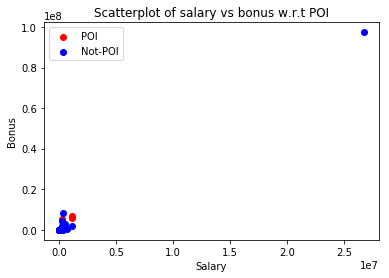

In [12]:
# Drawing scatterplot 

plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],enron_df_new['bonus'][enron_df_new['poi'] == True], color = 'r',
           label = 'POI')
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],enron_df_new['bonus'][enron_df_new['poi'] == False],color = 'b',
           label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary vs bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show()  

From the above figure, one point has high value of salary and bonus.

In [13]:
enron_df_new['salary'].argmax()

'TOTAL'

So the 'TOTAL' row is removed from the above df.

In [14]:
enron_df_new.drop('TOTAL', axis = 0, inplace = True)
enron_df_new.shape

(145, 20)

So the scatterplot for the changed df is.

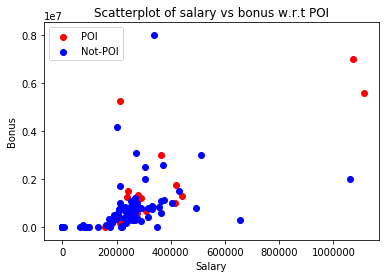

In [15]:
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == True],enron_df_new['bonus'][enron_df_new['poi'] == True], color = 'r',
           label = 'POI')
plt.scatter(enron_df_new['salary'][enron_df_new['poi'] == False],enron_df_new['bonus'][enron_df_new['poi'] == False],color = 'b',
           label = 'Not-POI')
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary vs bonus w.r.t POI")
plt.legend(loc='upper left')
plt.show() 

As the POI's were taking larger amounts of money as bonus, in addition to their high salary so it can be stated that the ratio of bonus to salary of the POI's will be higher as compared to that of non-POI's. 

#### Feature created :  bonus-to-salary_ratio

In [16]:
# Created a new feature
enron_df_new['bonus-to-salary_ratio'] = enron_df_new['bonus']/enron_df_new['salary']

#### 2. Deferred_income, deferred_payment and total_payment 

According to [BusinessDictionary.com](http://www.businessdictionary.com/definition/deferred-payment.html) : Deferred payment is "a loan arrangement in which the borrower is allowed to start making payments at some specified time in the future. Deferred payment arrangements are often used in retail settings where a person buys and receives an item with a commitment to begin making payments at a future date."

[Deferred income](https://en.wikipedia.org/wiki/Deferred_income) : (also known as deferred revenue, unearned revenue, or unearned income) is, in accrual accounting, money received for goods or services which have not yet been delivered. According to the revenue recognition principle, it is recorded as a liability until delivery is made, at which time it is converted into revenue.

As Enron scam involved a lot of undisclosed assets and cheating public by selling assets to shell companies at end of each month and buying them back at the start of next month to hide the acounting losses so there are chances that lot of deferred revenue by the company was used by the POI's.

In [17]:
enron_df_new['deferred_income'].describe()

count    1.450000e+02
mean    -1.923475e+05
std      6.041174e+05
min     -3.504386e+06
25%     -3.666600e+04
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: deferred_income, dtype: float64

The __deferred_income__ feature has mostly negative values as it is the money which has to be returned by the company.

In [18]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

print "length poi list : ",len(poi_rs)
print "length non-poi list : ",len(non_poi_rs)

length poi list :  18
length non-poi list :  127


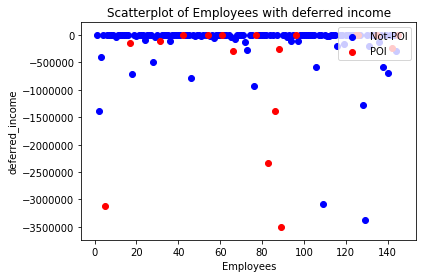

In [19]:
plt.scatter(non_poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('deferred_income')
plt.title("Scatterplot of Employees with deferred income")
plt.legend(loc='upper right')
plt.show()

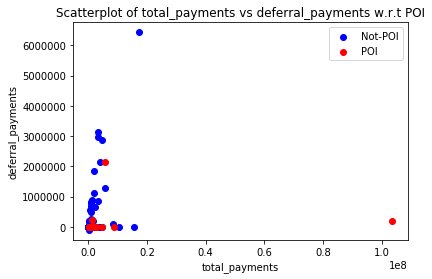

In [20]:
plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == False],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['total_payments'][enron_df_new['poi'] == True],
            enron_df_new['deferral_payments'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('total_payments')
plt.ylabel('deferral_payments')
plt.title("Scatterplot of total_payments vs deferral_payments w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above scatterplot it can be observed that majority of POIs have very low value of deferral payments as compared to the deferral_payments of non-POIs. 

So, from the above we can observe there are two outliers. The one having high value of total_payments is a POI and the other outlier with high value of deferral payments is a non-POI. I am removing the non-POI outlier.

In [21]:
enron_df_new['deferral_payments'].argmax()

'FREVERT MARK A'

### Removing the 2nd outlier

In [22]:
enron_df_new.drop('FREVERT MARK A', axis = 0, inplace = True)
enron_df_new.shape

(144, 21)

In [24]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

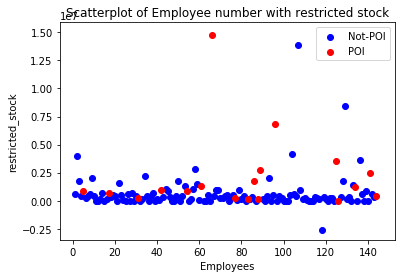

In [25]:
plt.scatter(non_poi_rs,
            enron_df_new['restricted_stock'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['restricted_stock'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('restricted_stock')
plt.title("Scatterplot of Employee number with restricted stock")
plt.legend(loc='upper right')
plt.show()

In [26]:
enron_df_new['restricted_stock'].argmax()

'LAY KENNETH L'

#### 3. long_term_incentive

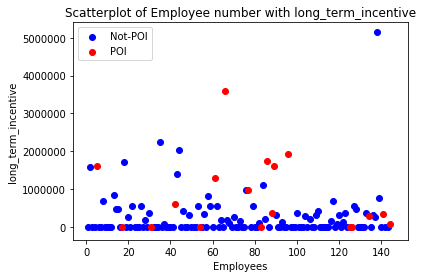

In [27]:
plt.scatter(non_poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['long_term_incentive'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('long_term_incentive')
plt.title("Scatterplot of Employee number with long_term_incentive")
plt.legend(loc='upper left')
plt.show()

In [28]:
enron_df_new['long_term_incentive'].argmax()

'MARTIN AMANDA K'

### Removing the 3rd outlier

In [29]:
enron_df_new.drop('MARTIN AMANDA K', axis = 0, inplace = True)
enron_df_new.shape

(143, 21)

#### 4. restricted_stock and restricted_stock_deferred

In [30]:
enron_df_new['restricted_stock_deferred'].describe()

count    1.430000e+02
mean     7.393131e+04
std      1.306545e+06
min     -1.787380e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.545629e+07
Name: restricted_stock_deferred, dtype: float64

In [31]:
enron_df_new['restricted_stock'].describe()

count    1.430000e+02
mean     8.453186e+05
std      2.004253e+06
min     -2.604490e+06
25%      1.623000e+04
50%      3.605280e+05
75%      6.985810e+05
max      1.476169e+07
Name: restricted_stock, dtype: float64

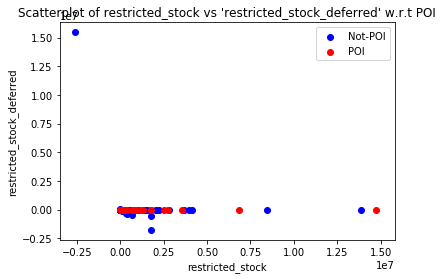

In [32]:
# Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == False],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['restricted_stock'][enron_df_new['poi'] == True],
            enron_df_new['restricted_stock_deferred'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('restricted_stock')
plt.ylabel('restricted_stock_deferred')
plt.title("Scatterplot of restricted_stock vs 'restricted_stock_deferred' w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

So obtained an outlier in the feature __restricted_stock_deferred__. Also taking a quick look at the values of __restricted_stock_deferred__ most of the values are zeros and the remaining few are negative values. The outlier found here is for the enron employee __BHATNAGAR SANJAY__ who is not a POI and in this analysis i am removing this datapoint hoping that it may aid in classification.  

And at the other axis of the graph, the other maximum values are of a POI and a non-POI so no need to remove them. 

In [33]:
enron_df_new['restricted_stock_deferred'].argmax()

'BHATNAGAR SANJAY'

In [34]:
enron_df_new.loc['BHATNAGAR SANJAY']['poi']

False

### Removing the 4th outlier

In [35]:
enron_df_new.drop('BHATNAGAR SANJAY', axis = 0, inplace = True)
enron_df_new.shape

(142, 21)

#### 5.  expenses

In [36]:
# Finding out the integer index locations of POIs and non-POIs
poi_rs = []
non_poi_rs = []
for i in range(len(enron_df_new['poi'])):
    if enron_df_new['poi'][i] == True:
        poi_rs.append(i+1)
    else:
        non_poi_rs.append(i+1)

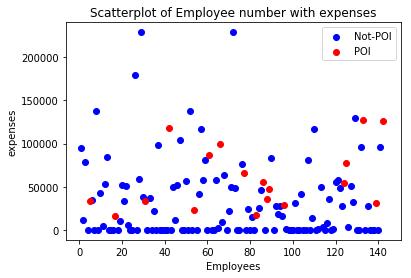

In [38]:
plt.scatter(non_poi_rs,
            enron_df_new['expenses'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['expenses'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('expenses')
plt.title("Scatterplot of Employee number with expenses")
plt.legend(loc='upper right')
plt.show()

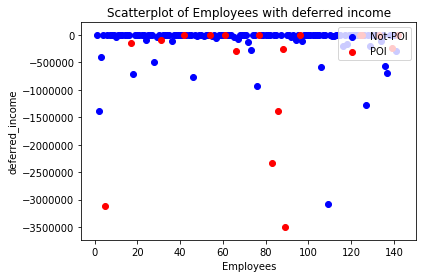

In [39]:
plt.scatter(non_poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(poi_rs,
            enron_df_new['deferred_income'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('Employees')
plt.ylabel('deferred_income')
plt.title("Scatterplot of Employees with deferred income")
plt.legend(loc='upper right')
plt.show()

### Email-Features
Also it can be thought that for doing such a big scam the POI's might have frequent contact between them via E-mails so by checking on the number of  e-mails transferred between POIs and an Employee we can be able to guess for the involvement of that person in that scam. So finding the fraction of the mail from and to this person with respect to the POI.

#### 1.  from_poi_to_this_person and from_this_person_to_poi

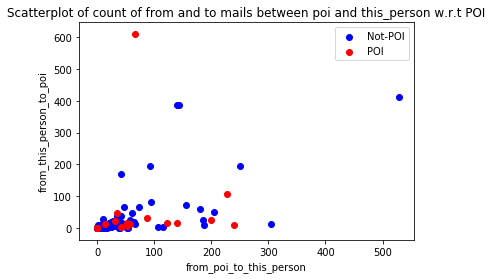

In [40]:
plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == False],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['from_poi_to_this_person'][enron_df_new['poi'] == True],
            enron_df_new['from_this_person_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('from_poi_to_this_person')
plt.ylabel('from_this_person_to_poi')
plt.title("Scatterplot of count of from and to mails between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

#### Features created : fraction_mail_from_poi and fraction_mail_to_poi

In [41]:
enron_df_new['fraction_mail_from_poi'] = enron_df_new['from_poi_to_this_person']/enron_df_new['from_messages'] 
enron_df_new['fraction_mail_to_poi'] = enron_df_new['from_this_person_to_poi']/enron_df_new['to_messages']

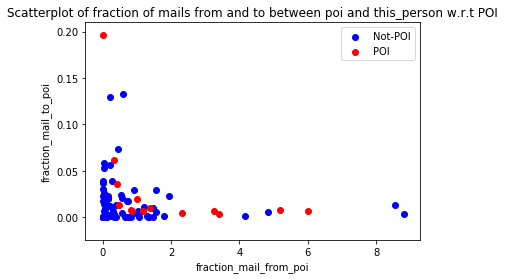

In [42]:
plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == False],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_df_new['fraction_mail_from_poi'][enron_df_new['poi'] == True],
            enron_df_new['fraction_mail_to_poi'][enron_df_new['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('fraction_mail_from_poi')
plt.ylabel('fraction_mail_to_poi')
plt.title("Scatterplot of fraction of mails from and to between poi and this_person w.r.t POI")
plt.legend(loc='upper right')
plt.show() 

From the above figure, the difference between POIs and non-POIs points can be clearly classified.  

So the total number of features in the dataframe after the data analysis is.

In [43]:
enron_df_new.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'exercised_stock_options', u'expenses', u'from_messages',
       u'from_poi_to_this_person', u'from_this_person_to_poi',
       u'loan_advances', u'long_term_incentive', u'other', u'poi',
       u'restricted_stock', u'restricted_stock_deferred', u'salary',
       u'shared_receipt_with_poi', u'to_messages', u'total_payments',
       u'total_stock_value', u'bonus-to-salary_ratio',
       u'fraction_mail_from_poi', u'fraction_mail_to_poi'],
      dtype='object')

In [44]:
enron_df_new.shape

(142, 23)

In [45]:
new_features_list = enron_df_new.columns.values
new_features_list

array(['bonus', 'deferral_payments', 'deferred_income', 'director_fees',
       'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi',
       'loan_advances', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'restricted_stock_deferred', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value', 'bonus-to-salary_ratio',
       'fraction_mail_from_poi', 'fraction_mail_to_poi'], dtype=object)

In [68]:
#clean all 'inf' values which we got if the person's from_messages = 0
enron_df_new = enron_df_new.replace('inf', 0)
enron_df_new = enron_df_new.fillna(0)
# Converting the above modified dataframe to a dictionary
enron_dict = enron_df_new.to_dict('index')

In [69]:
print "Features of modified data_dictionary  \n"
print "Total number of datapoints : ",len(enron_dict)
print "Total number of features : ",len(enron_dict['METTS MARK'])

Features of modified data_dictionary  

Total number of datapoints :  142
Total number of features :  23


In [70]:
for key, value in enron_dict.iteritems():
    print key
    print "\n"
    for val in enron_dict[key].keys():
        print val
    break


METTS MARK


to_messages
deferral_payments
expenses
poi
long_term_incentive
shared_receipt_with_poi
from_poi_to_this_person
deferred_income
restricted_stock_deferred
bonus-to-salary_ratio
loan_advances
from_messages
other
director_fees
fraction_mail_from_poi
bonus
total_stock_value
from_this_person_to_poi
restricted_stock
salary
total_payments
fraction_mail_to_poi
exercised_stock_options


## Feature Scaling

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [72]:
# Store to my_dataset for easy export below.
my_dataset = enron_dict

In [73]:
## Slecting features which i think might be important
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'bonus-to-salary_ratio', 'deferral_payments', 'expenses',
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','fraction_mail_from_poi', 
                 'fraction_mail_to_poi', 'from_poi_to_this_person', 'from_this_person_to_poi']

In [74]:
# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Task 4: Try a varity of classifiers

In [75]:
### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, 
                                                                                             random_state=42)

### Classifer 1 : Naive Bayes 

In [77]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

t0 = time()
clf = clf.fit(features_train, labels_train)
print "training time: ", round(time()-t0, 3), "s"

t0 = time()
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of GaussianNB classifer is  : ",accuracy_score(labels_test, prediction)
print "Precision of GaussianNB classifer is : ",precision_score(prediction, labels_test)
print "recall of GaussianNB classifer is    : ",recall_score(prediction, labels_test)


training time:  0.002 s
testing time:  0.001 s
Accuracy of GaussianNB classifer is  :  0.658536585366
Precision of GaussianNB classifer is :  0.6
recall of GaussianNB classifer is    :  0.2
